In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [84]:
import os
from tensorflow.keras.preprocessing.image import DirectoryIterator
from sklearn.model_selection import train_test_split

In [85]:
path = '../catchafish/data'

In [86]:
def get_data(val_split = False, test_size = 0.3):
    '''This function returns the '''
    path = '../catchafish/data'
    batch_size = 100000
    
    dir_iterator = DirectoryIterator(directory = path, 
                                     image_data_generator = None, 
                                     target_size = (32, 32), 
                                     batch_size = batch_size,
                                     shuffle = False, 
                                     dtype = int)
    
    X = dir_iterator[0][0]
    y = dir_iterator.labels
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)
    
    if val_split:
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3)
        return X_train, X_val, X_test, y_train, y_val, y_test
    else:
        return X_train, X_test, y_train, y_test

In [96]:
X_train, X_val, X_test, y_train, y_val, y_test = get_data(val_split = True)

Found 312 images belonging to 8 classes.


In [97]:
X_train.shape

(152, 32, 32, 3)

In [98]:
X_test.shape

(94, 32, 32, 3)

In [99]:
y_test[:15]

array([2, 7, 7, 4, 2, 2, 7, 5, 6, 3, 5, 7, 1, 1, 3], dtype=int32)

In [91]:
X_train, X_test, y_train, y_test = get_data()

Found 312 images belonging to 8 classes.


In [92]:
X_train.shape

(218, 32, 32, 3)

In [93]:
X_test.shape

(94, 32, 32, 3)

In [95]:
y_test[:15]

array([2, 7, 7, 4, 2, 2, 7, 5, 6, 3, 5, 7, 1, 1, 3], dtype=int32)

In [80]:
dir_iterator = DirectoryIterator(directory = path, 
                                 image_data_generator = None, 
                                 target_size = (32, 32), 
                                 batch_size = 315,
                                 shuffle = False, 
                                 dtype = int)

Found 312 images belonging to 8 classes.


In [81]:
type(dir_iterator)

tensorflow.python.keras.preprocessing.image.DirectoryIterator

In [82]:
dir_iterator[0][0].shape

(312, 32, 32, 3)

In [69]:
dir_iterator[0][0]

array([[[[ 50, 147, 200],
         [ 49, 146, 199],
         [ 50, 145, 199],
         ...,
         [ 57, 165, 212],
         [ 60, 171, 214],
         [ 65, 172, 214]],

        [[ 49, 146, 201],
         [ 49, 146, 201],
         [ 50, 145, 201],
         ...,
         [ 57, 165, 212],
         [ 63, 172, 215],
         [ 59, 170, 215]],

        [[ 49, 146, 201],
         [ 47, 144, 199],
         [ 48, 143, 199],
         ...,
         [ 56, 164, 211],
         [ 63, 172, 215],
         [ 60, 171, 216]],

        ...,

        [[ 70,  68,  56],
         [ 50,  57,  41],
         [169, 179, 145],
         ...,
         [ 23,  28,  21],
         [ 22,  28,  18],
         [ 25,  35,  24]],

        [[ 84,  83,  55],
         [ 93, 103, 102],
         [150, 155, 135],
         ...,
         [ 25,  35,  24],
         [ 30,  42,  32],
         [ 31,  47,  36]],

        [[ 85,  84,  64],
         [ 55,  55,  55],
         [ 72,  83,  69],
         ...,
         [ 33,  47,  34],
        

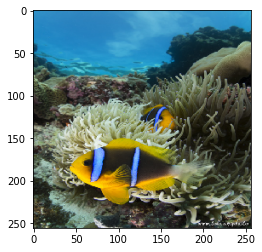

In [71]:
plt.imshow(dir_iterator[0][0][0])

In [56]:
dir_iterator[0][1][:10]

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [61]:
dir_iterator.labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,

In [ ]:
for image in dir_iterator:
    print(image[1].shape)

In [6]:
for root, dirs, files in os.walk('../catchafish/data'):
    for directory in dirs:
        path_to_directory = os.path.join(root, directory)